# The Battle of Neighborhoods

## Final Assignment for the Data Science Capstone

## Table of contents

1. [Introduction](#intro)
2. [Data Analysis](#data)
3. [Clustering](#clust)
4. [Results & Discussion](#res)
5. [Conclusion](#con)

## 1. Introduction <a name="intro"></a>

Athens (Greek: Αθήνα, romanized: Athína) is the capital and largest city of Greece. Athens dominates the Attica region and is one of the world's oldest cities, with its recorded history spanning over 3,400 years and its earliest human presence started somewhere between the 11th and 7th millennium BC.

I have lived here my whole life and I love the city vibes. Athens never sleeps (just like New York city) and people, not only the locals but also the overwhelming number of visitors, love going out, having drinks and eating at one of the thousand available restaurants. Thus, the aim of this project is to study the neighborhoods in Athens to determine possible locations for opening a restaurant. This project can be useful for business owners and entrepreneurs who are looking to invest in a restaurant in Athens. The main objective of this project is to carefully analyze appropriate data and find recommendations for the stakeholders.

## 2. Data Analysis <a name="data"></a>

The data required for this project has been collected from multiple sources. For a list of the neighbourhoods in Athens we used a Wikipedia page, while for their coordinates we used geocoder library. Next, we used Foursquare API to get all the available venues for each neighbourhood. So, our goal is to gather info about each neighbourhood and by analyzing the venues data from Foursquare, we can provide recommendations to stakeholders.

In the following sub-sections you can find a more detailed analysis of our data.

### 2.1 Neighbourhood Data

The data of Athens' neighbourhoods was scraped from https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Athens. The data is read into a pandas data frame using the read_html() method. The main reason for doing so is that the Wikipedia page provides a comprehensive list of most of Athens neighbourhoods. Later on, we will use geocoder to get their coordinates.

In [ ]:
##Run only the first time, if libraries are not installed

# !pip install geopy
# !pip install geocoder
# !pip install folium

In [1]:
import json
import geocoder
import requests
import folium

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score
from bs4 import BeautifulSoup

%matplotlib notebook

In [ ]:
##Change how jupyter displays data, mostly used for debugging
##Useful when displaying large DFs and arrays

# InteractiveShell.ast_node_interactivity = "all"
# pd.options.display.max_rows = None
# pd.options.display.max_columns = None

Initially, we use requests and BeautifulSoup to scrape the neighbourhoods from Wiki page. 

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Athens'
html_data = requests.get(wiki_url).text 
soup = BeautifulSoup(html_data, 'html5lib')

Browsing the URL, we can see that some neighbourhoods also contain the city name (i.e., Athens) in their title. For example:

Agios Eleftherios, Athens
Agios Panteleimonas, Athens
etc.

We do not need the city, so we split in ',' to get only the neighbourhood name.

In [3]:
athens_neighs = []

for entry in soup.find(id='mw-pages').find_all('li'):
    neigh_name = entry.get_text().split(',')[0]
    athens_neighs.append(neigh_name)
    
athens_neighs[:5]

['Aerides',
 'Agios Eleftherios',
 'Agios Panteleimonas',
 'Akadimia Platonos',
 'Akadimia']

We remove any duplicate entries by making a set and also remove the last, noisy value from Wikipedia's list (i.e., Template:Neighbourhoods in Athens)

In [4]:
print('Size before removals: {}'.format(len(athens_neighs)))

# drop duplicates using a set
athens_neighs = list(set(athens_neighs))

# remove last entry as it is of no value
try:
    athens_neighs.remove('Template:Neighbourhoods in Athens')
except ValueError:
    pass  # do nothing!

print('Size after removals: {}'.format(len(athens_neighs)))

Size before removals: 63
Size after removals: 61


So, as it seems we deleted one duplicate entry and the noisy one. Noice!

Now, let's get these neighbourhoods coordinates using geocoder library. We define a function that takes the neighbourhood name as input and returns the coordinates.

In [5]:
def get_coordinates(neigh: str):
    
    lat_lng_coords = None
    latitude = np.NaN
    longitude = np.NaN
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Athens, Greece'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    return [latitude, longitude]

Great, now for each neighbourhood, we get its coordinates using geocoder and store the final data into a new dataframe named: `athens_data`. As geocoder is not that reliable, the first time we obtain the coordinates we can save the `athens_data` to a .csv. On a possible re-run, we just load the .csv data.

In [6]:
use_geocoder = True

athens_data = pd.DataFrame(columns=['Neighbourhood', 'Latitude', 'Longitude'])

if use_geocoder:
    for neigh in athens_neighs:
        lat, lon = get_coordinates(neigh)
        athens_data = athens_data.append({'Neighbourhood': neigh, 'Latitude': lat, 'Longitude': lon}, ignore_index=True)
    
    # save the data to avoid using geocoder again :D
    # athens_data.to_csv('./athens_neighbourhoods.csv')
else:
    athens_data = pd.read_csv('./athens_neighbourhoods.csv', index_col=0)

athens_data.describe(include='all')

,Neighbourhood,Latitude,Longitude
count,61,61.000000,61.000000
unique,61,NaN,NaN
top,Ampelokipoi,NaN,NaN
freq,1,NaN,NaN
mean,NaN,37.986707,23.751412
std,NaN,0.046852,0.481309
min,NaN,37.778580,21.761250
25%,NaN,37.974380,23.717940
50%,NaN,37.979190,23.729150
75%,NaN,37.993974,23.741480


In [44]:
athens_data.head(10)

,Neighbourhood,Latitude,Longitude
0,Makrygianni,37.96807,23.72687
1,Kallimarmaro,37.96691,23.74022
2,Girokomeio,38.23802,21.76125
3,Agios Eleftherios,38.01997,23.72627
4,Neos Kosmos,37.96142,23.72871
5,Kolonaki,37.97762,23.74359
6,Nea Filothei,37.99682,23.76311
7,Thiseio,37.97481,23.71592
8,Asteroskopeio,37.97438,23.71920
9,Koukaki,37.96372,23.72353


Time to plot the data, just to be sure that the coordinates are right! First, let's get Athens coordinates to center the map and then plot all the neighbourhoods.

In [7]:
address = 'Athens, GR'
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Athens are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Athens are 37.9839412, 23.7283052.


In [8]:
athens_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighbourhood in zip(athens_data['Latitude'], athens_data['Longitude'], athens_data['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='brown',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        parse_html=False).add_to(athens_map)  
    
athens_map

### 2.2 Using Foursquare API

Now we can start working with the Foursquare API to obtain venue recommendations.

Lets create the Foursquare credentials first.

In [9]:
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret

VERSION = '20180604'

We use the function `getNearbyVenues` to get venues for all the available neighbourhoods.

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    """
    This functions returns a data frame of the top 100 locations for each neighborhod given it's latitute and longitude.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Searching for venues in: {}'.format(name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
athens_venues = getNearbyVenues(names=athens_data['Neighbourhood'],
                                   latitudes=athens_data['Latitude'],
                                   longitudes=athens_data['Longitude']
                                  )

print('\nTotal founds: {}'.format(athens_venues.shape))
print('Unique categories: {}\n'.format(len(athens_venues['Venue Category'].unique())))
athens_venues.head()

Searching for venues in: Makrygianni
Searching for venues in: Kallimarmaro
Searching for venues in: Girokomeio
Searching for venues in: Agios Eleftherios
Searching for venues in: Neos Kosmos
Searching for venues in: Kolonaki
Searching for venues in: Nea Filothei
Searching for venues in: Thiseio
Searching for venues in: Asteroskopeio
Searching for venues in: Koukaki
Searching for venues in: Kountouriotika
Searching for venues in: Patisia
Searching for venues in: Rouf
Searching for venues in: Votanikos
Searching for venues in: Ano Petralona
Searching for venues in: Kolonos
Searching for venues in: Ilisia
Searching for venues in: Ellinoroson
Searching for venues in: Petralona
Searching for venues in: Akadimia Platonos
Searching for venues in: Vathi
Searching for venues in: Kypseli
Searching for venues in: Evangelismos
Searching for venues in: Goudi
Searching for venues in: Pedion tou Areos
Searching for venues in: Anafiotika
Searching for venues in: Probonas
Searching for venues in: Neapo

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Makrygianni,37.96807,23.72687,Acropolis Museum (Μουσείο Ακρόπολης),37.968821,23.728256,History Museum
1,Makrygianni,37.96807,23.72687,Drupes & Drips,37.967748,23.726715,Coffee Shop
2,Makrygianni,37.96807,23.72687,Little Tree Books & Coffee,37.968179,23.727135,Café
3,Makrygianni,37.96807,23.72687,Guarantee,37.966230,23.726184,Sandwich Place
4,Makrygianni,37.96807,23.72687,Lotte,37.967173,23.727185,Café


Let's see how many venues we got per neighbourhood.

In [12]:
athens_venues.groupby('Neighbourhood', as_index=False).count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aerides,70,70,70,70,70,70
1,Agios Eleftherios,24,24,24,24,24,24
2,Agios Panteleimonas,21,21,21,21,21,21
3,Akadimia,11,11,11,11,11,11
4,Akadimia Platonos,17,17,17,17,17,17
...,...,...,...,...,...,...,...
56,Thiseio,88,88,88,88,88,88
57,Thymarakia,31,31,31,31,31,31
58,Treis Gefyres,70,70,70,70,70,70
59,Vathi,42,42,42,42,42,42


Now, let's plot a histogram to see the frequency of venues happening in neighbourhoods.

<IPython.core.display.Javascript object>


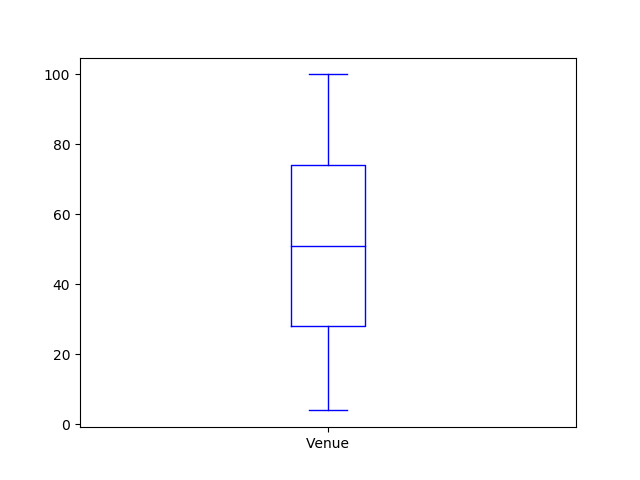

In [42]:
athens_venues.groupby('Neighbourhood', as_index=False).count()['Venue'].plot(kind='box', color='blue')

### 2.3 Analyze Each Neighbourhood

We can start analyzing each neighborhood by One-hot Encoding to see which categories belong in which neighbourhoods.

In [14]:
athens_onehot = pd.get_dummies(athens_venues[['Venue Category']], prefix='', prefix_sep='')
athens_onehot.head()

,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After we got the venue categories encoded, we add the `Neighbourhood` column in the first column.

In [15]:
athens_onehot['Neighbourhood'] = athens_venues['Neighbourhood']

temp = list(athens_onehot.columns)

if 'Neighbourhood' in temp:
    temp.remove('Neighbourhood')
    
fixed_columns = ['Neighbourhood'] + temp
athens_onehot = athens_onehot[fixed_columns]

athens_onehot.head()

,Neighbourhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Makrygianni,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Makrygianni,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Makrygianni,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Makrygianni,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Makrygianni,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can groupby `Neighbourhood` and take the mean for all categories.

In [16]:
athens_grouped = athens_onehot.groupby('Neighbourhood', sort=False).mean().reset_index()
print(athens_grouped.shape)
athens_grouped.head(10)

(61, 230)


,Neighbourhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Store,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Makrygianni,0.0,0.000000,0.010000,0.010000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.010000,0.000000,0.0,0.000000,0.040000,0.000000,0.000000,0.010000
1,Kallimarmaro,0.0,0.000000,0.000000,0.013514,0.013514,0.0,0.000000,0.0,0.000000,...,0.0,0.013514,0.013514,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,Girokomeio,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Agios Eleftherios,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,Neos Kosmos,0.0,0.000000,0.013333,0.013333,0.000000,0.0,0.000000,0.0,0.013333,...,0.0,0.000000,0.013333,0.000000,0.0,0.000000,0.026667,0.000000,0.000000,0.000000
5,Kolonaki,0.0,0.012346,0.000000,0.024691,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.012346,0.000000,0.012346,0.012346,0.000000
6,Nea Filothei,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.029851,0.0,0.000000,...,0.0,0.000000,0.000000,0.014925,0.0,0.000000,0.000000,0.000000,0.000000,0.014925
7,Thiseio,0.0,0.000000,0.000000,0.011364,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,Asteroskopeio,0.0,0.000000,0.000000,0.011628,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.011628,0.000000,0.000000,0.000000
9,Koukaki,0.0,0.000000,0.015625,0.000000,0.000000,0.0,0.015625,0.0,0.000000,...,0.0,0.000000,0.015625,0.000000,0.0,0.000000,0.031250,0.000000,0.000000,0.000000


To understand the data better, we display the top 15 venues of all neighbourhoods.

In [17]:
num_top_venues = 15

for hood in athens_grouped['Neighbourhood']:
    print("# " + hood)
    temp = athens_grouped[athens_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

# Makrygianni
               venue  freq
0               Café  0.10
1   Greek Restaurant  0.10
2              Hotel  0.09
3      Historic Site  0.08
4        Coffee Shop  0.05
5           Wine Bar  0.04
6             Bistro  0.03
7                Bar  0.03
8   Pedestrian Plaza  0.03
9          Gastropub  0.02
10    Ice Cream Shop  0.02
11         Juice Bar  0.02
12            Hostel  0.02
13     Souvlaki Shop  0.02
14          Creperie  0.02


# Kallimarmaro
                 venue  freq
0                 Café  0.15
1     Greek Restaurant  0.07
2                  Bar  0.07
3         Cocktail Bar  0.05
4          Sports Club  0.04
5   Italian Restaurant  0.04
6              Kafenio  0.03
7        Grocery Store  0.03
8               Bakery  0.03
9                  Gym  0.03
10         Pizza Place  0.03
11               Plaza  0.03
12             Taverna  0.03
13               Hotel  0.01
14       Souvlaki Shop  0.01


# Girokomeio
                            venue  freq
0                G

                      venue  freq
0                      Café  0.11
1           Meze Restaurant  0.11
2                       Bar  0.08
3          Greek Restaurant  0.06
4              Cocktail Bar  0.06
5               Coffee Shop  0.06
6         Cretan Restaurant  0.03
7              Cupcake Shop  0.03
8             Souvlaki Shop  0.03
9   Modern Greek Restaurant  0.03
10                 Pie Shop  0.03
11          Other Nightlife  0.03
12             Dessert Shop  0.03
13                    Plaza  0.03
14              Supermarket  0.03


# Akadimia Platonos
                   venue  freq
0            Coffee Shop  0.29
1               Bus Stop  0.12
2            Snack Place  0.12
3            Supermarket  0.12
4         Hardware Store  0.06
5                Kafenio  0.06
6           Dessert Shop  0.06
7                   Park  0.06
8                   Café  0.06
9       Greek Restaurant  0.06
10          Optical Shop  0.00
11       Organic Grocery  0.00
12  Other Great Outdoors  0.00


                       venue  freq
0                        Bar  0.12
1           Greek Restaurant  0.10
2            Meze Restaurant  0.10
3                      Hotel  0.05
4                       Café  0.05
5               Dessert Shop  0.03
6   Mediterranean Restaurant  0.03
7                 Art Museum  0.03
8              Historic Site  0.03
9    Grilled Meat Restaurant  0.03
10          Pedestrian Plaza  0.02
11               Music Venue  0.02
12             Hot Dog Joint  0.02
13                Playground  0.02
14                 Nightclub  0.02


# Ampelokipoi
              venue  freq
0              Café  0.10
1      Dance Studio  0.07
2            Bakery  0.07
3               Bar  0.06
4   Meze Restaurant  0.05
5      Dessert Shop  0.05
6     Souvlaki Shop  0.03
7               Gym  0.03
8        Donut Shop  0.02
9       Supermarket  0.02
10      Coffee Shop  0.02
11          Taverna  0.02
12              Spa  0.02
13          Theater  0.02
14    Movie Theater  0.02


# Meta

14           Other Great Outdoors  0.00


# Gouva
                     venue  freq
0              Supermarket  0.14
1         Greek Restaurant  0.14
2            Souvlaki Shop  0.11
3                    Plaza  0.07
4          Meze Restaurant  0.07
5                 Pharmacy  0.04
6                   Bakery  0.04
7                Pet Store  0.04
8       Basketball Stadium  0.04
9        Mobile Phone Shop  0.04
10  Furniture / Home Store  0.04
11            Burger Joint  0.04
12       Convenience Store  0.04
13             Coffee Shop  0.04
14           Grocery Store  0.04




Lets now create a dataframe with the top 15 common venues for each neighborhood.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 15

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    columns.append('Venue ({})'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = athens_grouped['Neighbourhood']

for ind in np.arange(athens_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(athens_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Neighbourhood,Venue (1),Venue (2),Venue (3),Venue (4),Venue (5),Venue (6),Venue (7),Venue (8),Venue (9),Venue (10),Venue (11),Venue (12),Venue (13),Venue (14),Venue (15)
0,Makrygianni,Café,Greek Restaurant,Hotel,Historic Site,Coffee Shop,Wine Bar,Bistro,Pedestrian Plaza,Bar,Theater,Juice Bar,Gastropub,Souvlaki Shop,Hostel,Creperie
1,Kallimarmaro,Café,Greek Restaurant,Bar,Cocktail Bar,Sports Club,Italian Restaurant,Bakery,Gym,Grocery Store,Pizza Place,Taverna,Plaza,Kafenio,Mediterranean Restaurant,Martial Arts School
2,Girokomeio,Greek Restaurant,Golf Course,Taverna,Flower Shop,Gourmet Shop,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Yoga Studio
3,Agios Eleftherios,Greek Restaurant,Café,Supermarket,Taverna,Pharmacy,Donut Shop,Farmers Market,River,Coffee Shop,Shipping Store,Snack Place,Bus Stop,Grocery Store,Gym,Bookstore
4,Neos Kosmos,Greek Restaurant,Café,Bakery,Hotel,Coffee Shop,Supermarket,Dessert Shop,Souvlaki Shop,Bar,Wine Bar,Dance Studio,Mobile Phone Shop,Grilled Meat Restaurant,Theater,Gaming Cafe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,Aerides,Café,Gourmet Shop,Cocktail Bar,Coffee Shop,Dessert Shop,Hotel,Plaza,Pedestrian Plaza,Bookstore,Sushi Restaurant,Cosmetics Shop,Boutique,Nightclub,Roof Deck,Souvlaki Shop
57,Mets,Greek Restaurant,Supermarket,Bar,Café,Vegetarian / Vegan Restaurant,Gym,Hotel,Tennis Court,Food Truck,Pie Shop,Pizza Place,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store
58,Profitis Ilias,Plaza,Supermarket,Soccer Field,Theater,Stadium,Flower Shop,Golf Course,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant
59,Gyzi,Deli / Bodega,Pharmacy,Dessert Shop,Café,Motorcycle Shop,Soccer Field,Bakery,Sports Club,IT Services,Event Space,Dive Bar,Gift Shop,Donut Shop,Gay Bar,Dry Cleaner


## 3. Cluestering <a name="clust"></a>

Now we can use KMeans clustering method to cluster the neighbourhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance. 

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters.

![image info](https://2.bp.blogspot.com/-dQi4lSpbbnw/Wpr7iFzrjFI/AAAAAAAACps/qliCgVQ1gW4Jrri_UT_7d9JKI_LXd0n8wCLcBGAs/s1600/ssi-formula.png)

In [20]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [21]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = athens_grouped.drop('Neighbourhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=2).fit_predict(cl_df)
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.3908568788272436, 0.06944332357905238, 0.06763089586963668, 0.11846087206115864, 0.0755383858617537, 0.13139555932991417, 0.10073576305055357, 0.10360538341267098, 0.07106924001129844, 0.06990145210608092, 0.11964058699592434, 0.09556637476006123, 0.09010989411701047, 0.0709984276743609]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


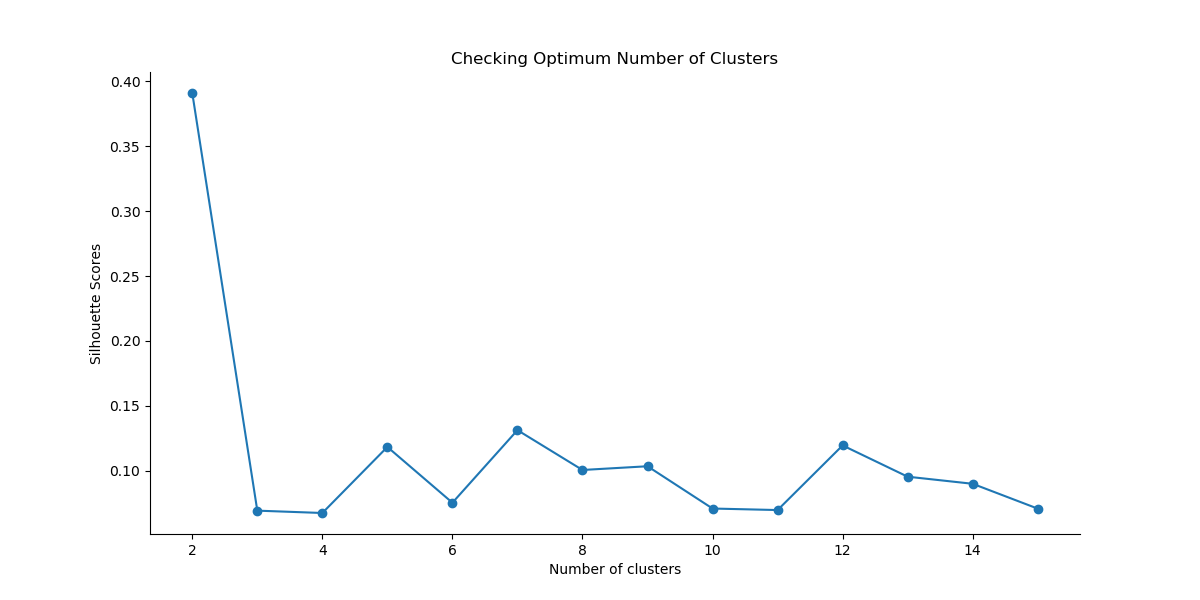

In [22]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not that high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. 

However, we will try to cluster our data as best as we can. For this, we will use 2 clusters for our clustering model since it provides the highest score for k=2.

This is expected as most of downtown places in Athens have a lot of venues about restaurants, bars, cafe etc.

In [23]:
k = 2

athens_clustering = athens_grouped.drop('Neighbourhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42).fit(athens_clustering)

kmeans.labels_

array([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0])

Now we can create a new dataframe that includes cluster labels and the top 15 venues.

In [24]:
# neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighbourhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

athens_merged = athens_data
athens_merged = athens_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Now, let's see the merged DF!

In [25]:
print(athens_merged.shape)
athens_merged.head(10)

(61, 19)


,Neighbourhood,Latitude,Longitude,Venue (1),Venue (2),Venue (3),Venue (4),Venue (5),Venue (6),Venue (7),Venue (8),Venue (9),Venue (10),Venue (11),Venue (12),Venue (13),Venue (14),Venue (15),Cluster Labels
0,Makrygianni,37.96807,23.72687,Café,Greek Restaurant,Hotel,Historic Site,Coffee Shop,Wine Bar,Bistro,Pedestrian Plaza,Bar,Theater,Juice Bar,Gastropub,Souvlaki Shop,Hostel,Creperie,1
1,Kallimarmaro,37.96691,23.74022,Café,Greek Restaurant,Bar,Cocktail Bar,Sports Club,Italian Restaurant,Bakery,Gym,Grocery Store,Pizza Place,Taverna,Plaza,Kafenio,Mediterranean Restaurant,Martial Arts School,1
2,Girokomeio,38.23802,21.76125,Greek Restaurant,Golf Course,Taverna,Flower Shop,Gourmet Shop,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Yoga Studio,0
3,Agios Eleftherios,38.01997,23.72627,Greek Restaurant,Café,Supermarket,Taverna,Pharmacy,Donut Shop,Farmers Market,River,Coffee Shop,Shipping Store,Snack Place,Bus Stop,Grocery Store,Gym,Bookstore,1
4,Neos Kosmos,37.96142,23.72871,Greek Restaurant,Café,Bakery,Hotel,Coffee Shop,Supermarket,Dessert Shop,Souvlaki Shop,Bar,Wine Bar,Dance Studio,Mobile Phone Shop,Grilled Meat Restaurant,Theater,Gaming Cafe,1
5,Kolonaki,37.97762,23.74359,Café,Gourmet Shop,Italian Restaurant,Dessert Shop,Greek Restaurant,Museum,Plaza,Park,Hotel,Playground,Art Museum,Grilled Meat Restaurant,Cupcake Shop,Boutique,Cosmetics Shop,1
6,Nea Filothei,37.99682,23.76311,Café,Bar,Souvlaki Shop,Dessert Shop,Park,Supermarket,Taverna,Pub,Dance Studio,Bakery,Asian Restaurant,Meze Restaurant,Fishing Store,Gaming Cafe,Italian Restaurant,1
7,Thiseio,37.97481,23.71592,Café,Bar,Nightclub,Greek Restaurant,Meze Restaurant,Music Venue,Park,Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Theater,Hotel,Bagel Shop,Creperie,Bakery,0
8,Asteroskopeio,37.97438,23.71920,Café,Meze Restaurant,Bar,Greek Restaurant,Historic Site,Hotel,Park,Performing Arts Venue,Nightclub,Indian Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Restaurant,Coffee Shop,Spa,0
9,Koukaki,37.96372,23.72353,Café,Hotel,Coffee Shop,Bar,Pizza Place,Wine Bar,Dessert Shop,Cosmetics Shop,Pedestrian Plaza,Meze Restaurant,Souvlaki Shop,Supermarket,Gymnastics Gym,Creperie,Grilled Meat Restaurant,1


Next, we can visualize the clustering by creating a map.

In [26]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)**2))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(athens_merged['Latitude'], athens_merged['Longitude'], athens_merged['Neighbourhood'], athens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1
#### Neighbourhoods and Venues

In [27]:
athens_merged.loc[athens_merged['Cluster Labels'] == 0, athens_merged.columns[[0] + [1] + list(range(4, athens_merged.shape[1]))]]

,Neighbourhood,Latitude,Venue (2),Venue (3),Venue (4),Venue (5),Venue (6),Venue (7),Venue (8),Venue (9),Venue (10),Venue (11),Venue (12),Venue (13),Venue (14),Venue (15),Cluster Labels
2,Girokomeio,38.238020,Golf Course,Taverna,Flower Shop,Gourmet Shop,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Yoga Studio,0
7,Thiseio,37.974810,Bar,Nightclub,Greek Restaurant,Meze Restaurant,Music Venue,Park,Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Theater,Hotel,Bagel Shop,Creperie,Bakery,0
8,Asteroskopeio,37.974380,Meze Restaurant,Bar,Greek Restaurant,Historic Site,Hotel,Park,Performing Arts Venue,Nightclub,Indian Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Restaurant,Coffee Shop,Spa,0
10,Kountouriotika,37.988560,Meze Restaurant,Dessert Shop,History Museum,Bookstore,Coffee Shop,Neighborhood,Cocktail Bar,Greek Restaurant,Restaurant,Flower Shop,Music Store,Bus Station,Magirio,Theater,0
12,Rouf,37.976830,Theater,Nightclub,Café,Greek Restaurant,Cocktail Bar,Restaurant,Gay Bar,Dance Studio,Gym,Movie Theater,Coffee Shop,Nail Salon,Cultural Center,Snack Place,0
14,Ano Petralona,37.969480,Café,Bar,Coffee Shop,Greek Restaurant,Cocktail Bar,Nightclub,Modern Greek Restaurant,Other Nightlife,Cretan Restaurant,Cupcake Shop,Thai Restaurant,Pub,Fast Food Restaurant,Kebab Restaurant,0
18,Petralona,37.969480,Café,Bar,Coffee Shop,Greek Restaurant,Cocktail Bar,Nightclub,Modern Greek Restaurant,Other Nightlife,Cretan Restaurant,Cupcake Shop,Thai Restaurant,Pub,Fast Food Restaurant,Kebab Restaurant,0
20,Vathi,37.778580,Bar,Hotel,Café,Cocktail Bar,Beach,Lounge,Seafood Restaurant,Mediterranean Restaurant,Surf Spot,Steakhouse,BBQ Joint,Meze Restaurant,Pub,Italian Restaurant,0
27,Neapoli,37.986780,Bar,Café,Meze Restaurant,Movie Theater,Theater,Coffee Shop,Plaza,Pizza Place,Bookstore,Souvlaki Shop,Cocktail Bar,Cretan Restaurant,Park,Dessert Shop,0
28,Profitis Daniil,37.984610,Greek Restaurant,Bar,Theater,Coffee Shop,Cocktail Bar,Betting Shop,Mediterranean Restaurant,Nightclub,Restaurant,Snack Place,Modern Greek Restaurant,Asian Restaurant,Café,Kafenio,0


### Cluster 2
#### Neighbourhoods and Venues

In [28]:
athens_merged.loc[athens_merged['Cluster Labels'] == 1, athens_merged.columns[[0] + [1] + list(range(4, athens_merged.shape[1]))]]

,Neighbourhood,Latitude,Venue (2),Venue (3),Venue (4),Venue (5),Venue (6),Venue (7),Venue (8),Venue (9),Venue (10),Venue (11),Venue (12),Venue (13),Venue (14),Venue (15),Cluster Labels
0,Makrygianni,37.968070,Greek Restaurant,Hotel,Historic Site,Coffee Shop,Wine Bar,Bistro,Pedestrian Plaza,Bar,Theater,Juice Bar,Gastropub,Souvlaki Shop,Hostel,Creperie,1
1,Kallimarmaro,37.966910,Greek Restaurant,Bar,Cocktail Bar,Sports Club,Italian Restaurant,Bakery,Gym,Grocery Store,Pizza Place,Taverna,Plaza,Kafenio,Mediterranean Restaurant,Martial Arts School,1
3,Agios Eleftherios,38.019970,Café,Supermarket,Taverna,Pharmacy,Donut Shop,Farmers Market,River,Coffee Shop,Shipping Store,Snack Place,Bus Stop,Grocery Store,Gym,Bookstore,1
4,Neos Kosmos,37.961420,Café,Bakery,Hotel,Coffee Shop,Supermarket,Dessert Shop,Souvlaki Shop,Bar,Wine Bar,Dance Studio,Mobile Phone Shop,Grilled Meat Restaurant,Theater,Gaming Cafe,1
5,Kolonaki,37.977620,Gourmet Shop,Italian Restaurant,Dessert Shop,Greek Restaurant,Museum,Plaza,Park,Hotel,Playground,Art Museum,Grilled Meat Restaurant,Cupcake Shop,Boutique,Cosmetics Shop,1
6,Nea Filothei,37.996820,Bar,Souvlaki Shop,Dessert Shop,Park,Supermarket,Taverna,Pub,Dance Studio,Bakery,Asian Restaurant,Meze Restaurant,Fishing Store,Gaming Cafe,Italian Restaurant,1
9,Koukaki,37.963720,Hotel,Coffee Shop,Bar,Pizza Place,Wine Bar,Dessert Shop,Cosmetics Shop,Pedestrian Plaza,Meze Restaurant,Souvlaki Shop,Supermarket,Gymnastics Gym,Creperie,Grilled Meat Restaurant,1
11,Patisia,38.020190,Coffee Shop,Café,Dessert Shop,Creperie,Bakery,Meze Restaurant,Souvlaki Shop,Kafenio,Beer Bar,Mobile Phone Shop,Furniture / Home Store,Cocktail Bar,Supermarket,Gym / Fitness Center,1
13,Votanikos,37.982830,Bus Stop,Business Service,Fish Taverna,Flower Shop,Golf Course,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,1
15,Kolonos,37.993340,Supermarket,Café,Plaza,Gym,Bakery,Pizza Place,Basketball Stadium,Gift Shop,Bus Station,Greek Restaurant,Grocery Store,Coffee Shop,Metro Station,Taverna,1


## 4. Results & Discussion <a name="res"></a>

By analyzing the 2 clusters obtained we can see that some neighbourhoods are more suited for restaurants and hotels, whereas, other are less suited. Neighbourhoods in cluster 2 contain a small percentage of restaurants, hotels, cafe and pubs in their top 20 common venues. This cluster contains a higher degree of other venues like fields and stadiums, theaters, supermarkets and various shops to name a few. 

Thus, they are not well suited for opening a new restaurant as it seems that people do not prefer these neighbourhoods when going out. Especially, this seems to hold true even for tourists. On the other hand, neighborhoods in cluster 1 contain a much higher degree of restaurants, hotels, cafes, bars and other food joints. Thus, the neighbourhoods in cluster 1 would be well suited for opening a new restaurant.

Comparing clusters 1 and 2, neighborhoods in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of food joints in the top 20 most common venues than cluster 2. The neighbourhoods in cluster 1 contain a variety of food joints like restaurants, bars, bakery, cafe, steakhouse and pubs and also contain very diverse cuisines like Greek, Indian, Chinese, Italian and seafood restaurants. Most neighborhoods in cluster 2 seem to have mostly generic shops and gyms or stadiums their top most common venue; 

Thus, it is recommended that the new restaurant should be opened in the neighborhoods belonging to cluster 1, as it seems to be more safe as an investment. However, if someone wants to take the risk and create a new restaurant in neighbourhoods of cluster 2, he may succeed as the competitors are not that many! Yet, the safe choice is cluster 1 neighbourhoods, so let's plot it in the final map.

In [30]:
new_restaurant_neighbourhoods = athens_merged.loc[athens_merged['Cluster Labels'] == 0, athens_merged.columns[[0, 1, 2, 3, 4] + list(range(5, athens_merged.shape[1]))]]
new_restaurant_neighbourhoods.head()

,Neighbourhood,Latitude,Longitude,Venue (1),Venue (2),Venue (3),Venue (4),Venue (5),Venue (6),Venue (7),Venue (8),Venue (9),Venue (10),Venue (11),Venue (12),Venue (13),Venue (14),Venue (15),Cluster Labels
2,Girokomeio,38.23802,21.761250,Greek Restaurant,Golf Course,Taverna,Flower Shop,Gourmet Shop,Gift Shop,Gay Bar,Gastropub,Garden Center,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,French Restaurant,Food Truck,Yoga Studio,0
7,Thiseio,37.97481,23.715920,Café,Bar,Nightclub,Greek Restaurant,Meze Restaurant,Music Venue,Park,Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Theater,Hotel,Bagel Shop,Creperie,Bakery,0
8,Asteroskopeio,37.97438,23.719200,Café,Meze Restaurant,Bar,Greek Restaurant,Historic Site,Hotel,Park,Performing Arts Venue,Nightclub,Indian Restaurant,Mediterranean Restaurant,Pedestrian Plaza,Restaurant,Coffee Shop,Spa,0
10,Kountouriotika,37.98856,23.735324,Bar,Meze Restaurant,Dessert Shop,History Museum,Bookstore,Coffee Shop,Neighborhood,Cocktail Bar,Greek Restaurant,Restaurant,Flower Shop,Music Store,Bus Station,Magirio,Theater,0
12,Rouf,37.97683,23.709890,Bar,Theater,Nightclub,Café,Greek Restaurant,Cocktail Bar,Restaurant,Gay Bar,Dance Studio,Gym,Movie Theater,Coffee Shop,Nail Salon,Cultural Center,Snack Place,0


In [43]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, neighbourhood in zip(new_restaurant_neighbourhoods['Latitude'], new_restaurant_neighbourhoods['Longitude'],
                                            new_restaurant_neighbourhoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

## 5. Conclusion <a name="con"></a>

We have successfully analyzed the neighbourhoods in Athens, Greece for determining which would be the best neighbourhoods for opening a new restaurant. Based on our analysis, neighbourhoods in cluster 1 are recommended as locations for the new restaurant. 

These neighbourhoods has also been plotted in the map above. The stakeholders and investors can further tune this by considering various other factors like transport, legal requirements, and costs associated. These were out of the scope for this project and thus were not considered.

### Note:

If maps are not show correctly, please see the rendered html version I hosted on the following url:

https://battle-of-neigh.tiiny.site/

# Thank you! 🤗